### HyDe

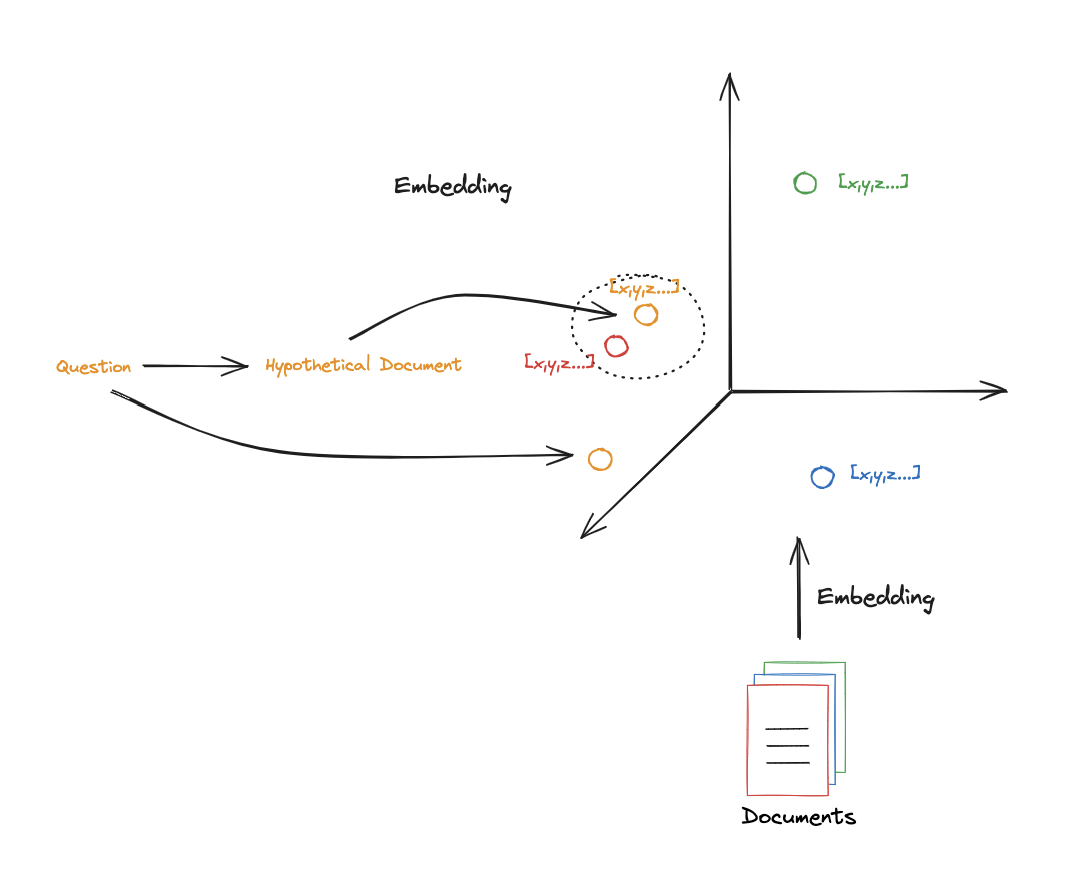

The below 2 code blocks give glimpse of what documents the vector db has just for reference

In [1]:
import pickle

with open('splits.pkl', 'rb') as f:
    splits = pickle.load(f)

In [2]:
splits[:3]

[Document(metadata={'source': 'k8s-joplin\\Kubernetes\\api-conventions.md'}, page_content='API Conventions\n\nThis document is oriented at users who want a deeper understanding of the Kubernetes API structure, and developers wanting to extend the Kubernetes API. An introduction to using resources with kubectl can be found in the object management overview.\n\nTable of Contents\n\nTypes (Kinds)\n\nResources\n\nObjects\n\nMetadata\n\nSpec and Status\n\nTypical status properties\n\nReferences to related objects\n\nLists of named subobjects preferred over maps\n\nPrimitive types\n\nConstants\n\nUnions\n\nLists and Simple kinds\n\nDiffering Representations\n\nVerbs on Resources\n\nPATCH operations\n\nShort-names and Categories\n\nShort-names\n\nCategories\n\nIdempotency\n\nOptional vs. Required\n\nDefaulting\n\nStatic Defaults\n\nAdmission Controlled Defaults\n\nController-Assigned Defaults (aka Late Initialization)\n\nWhat May Be Defaulted\n\nConsiderations For PUT Operations\n\nConcurrenc

### Create embeddings and load to vector database chromaDB

In [1]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_chroma import Chroma

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
persist_dir = "chromadb"
# db = Chroma.from_documents(documents=splits, embedding=embedding_function, persist_directory=persist_dir)
newdb = Chroma(persist_directory=persist_dir, embedding_function=embedding_function)

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Make sure to create .env file with gemini api key as we use Gemini 1.5 flash here as the LLM

Source - https://ai.google.dev/gemini-api/docs/api-key

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

In [3]:

from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7 )

### Creating a prompt template for generating HyDE

HypotheticalDocumentEmbedder is abstraction class which takes in LLM and embeddings and based on the "prompt_key", creates LLM chain. 

This takes care of creating hypothetical docs and embedding them only if you use method `embed_query()`

Refer to documentation of this class - https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/hyde/base.py

Also, the prompt_key has values as per this file - https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/hyde/prompts.py#L7


Here we will do the finding similar docs based on web search manually creating our own chain and prompts and not using the abstraction from above class

In [4]:
def printConversation(conversation):

    user_query = conversation['question']
    llm_answer = conversation['answer']
    sources = set()

    for doc in conversation['context']:
        sources.add(doc.metadata['source'])

    print(f"🗣️User: {user_query}")
    print(f"🤖AI: {llm_answer}")
    print("sources: ", ' ,'.join(list(sources)))
    
def getConversationResponse(conversation):

    user_query = conversation['question']
    llm_answer = conversation['answer']
    sources = set()

    for doc in conversation['context']:
        sources.add(doc.metadata['source'])

    return {
        "question": user_query,
        "answer": llm_answer,
        "sources": list(sources)
    }


In [8]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.prompts import ChatPromptTemplate

retriever = newdb.as_retriever(search_kwargs={"k":5})

def getWebResponseLLM(query):
    '''
    this method takes in user question and gives LLM generated output
    based on web search 
    '''
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful assistant who gives concise summary on inputs provided by human. Your response should be comprehensive and include all key points that would be found in the top search result and total length less than 250 words.",
            ),
            ("human", "{query}"),
        ]
    )

    chain = prompt | llm
    response =  chain.invoke(
        {
            "query": query
        }
    )
    return response.content


def format_docs(docs):
    # print("docs:", docs)
    return "\n\n".join(doc.page_content for doc in docs)


def answerUserQuery(query):
    print(query)
    # use hyde chromaDB as retriever

    # Get LLM response for question and find similar docs for the LLM response
    hypo_web_search_text = getWebResponseLLM(query)
    matched_docs = retriever.get_relevant_documents(query=hypo_web_search_text)

    prompt = ChatPromptTemplate.from_template("""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use five sentences maximum and keep the answer concise.
        Question: {question} 
        Context: {context} 
        Answer:""")

    rag_chain_from_docs = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | prompt
        | llm
        | StrOutputParser()
    )



    # here we pass the input values parallely to both
    # here we create dictionary with keys => context and question and assign them 
    # values as passed via invoke method on RunnableParallel
    # we also assign this dictionary object 'answer' once it gets computed from
    # chain 'rag_chain_from_docs'
    rag_chain_with_source = RunnableParallel(
    {"context": itemgetter("context"), "question": itemgetter("question")}
    ).assign(answer=rag_chain_from_docs)


    conversation = rag_chain_with_source.invoke({
        "question": query,
        "context": matched_docs # pass matched docs instead of retriever
    })
    
    printConversation(conversation)
    return getConversationResponse(conversation=conversation)
    
    

# We chose not using HypotheticalDocumentEmbedder as we wanted our embeddings to stay in same format having sources as well and using this class would change the data as per file - https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/hyde/base.py

# we initial embed our documents in specific Document() class and we do not want data to be stored in text format, for which we avoid this abstraction and write similar code.

In [8]:
answerUserQuery("What are volumes in Kubernetes?")

What are volumes in Kubernetes?


d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


🗣️User: What are volumes in Kubernetes?
🤖AI: Volumes in Kubernetes are storage units that can be attached to pods. They allow pods to access persistent data, like databases or files. There are different types of volumes, such as `emptyDir`, `secret`, and `persistentVolume`. The `persistentVolume` type is particularly important because it provides persistent storage that survives pod restarts. Volumes are managed by the Kubernetes control plane and are essential for running applications that require persistent data. 

sources:  k8s-joplin\Kubernetes\Volumes.md ,k8s-joplin\Kubernetes\Kubelet.md


#### Need to add validator which does not show sources if cannot answer question

### Workflow till now

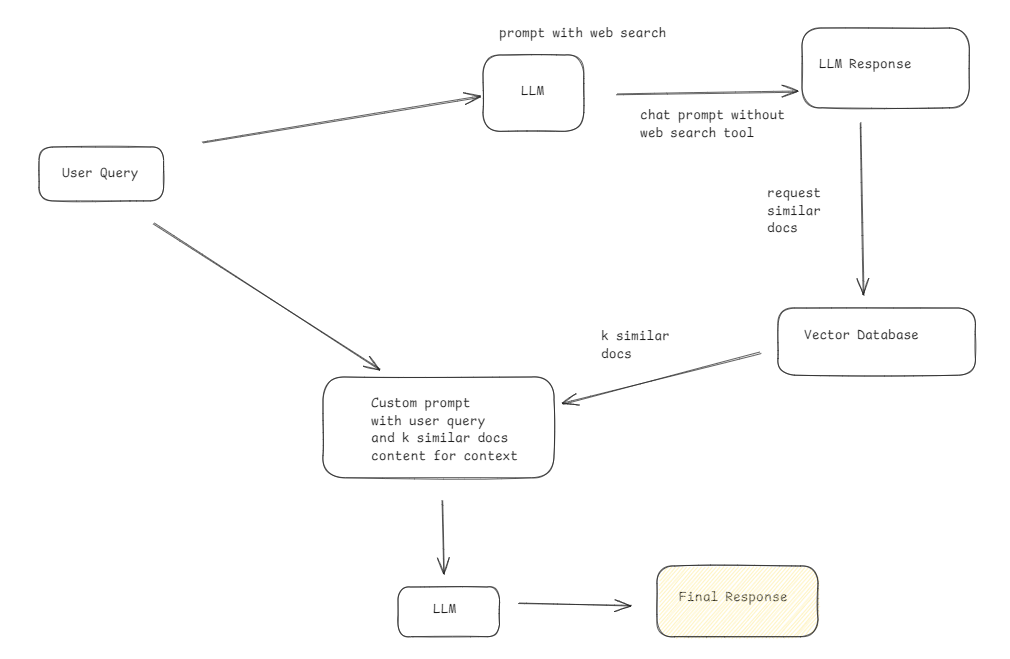

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.prompts import ChatPromptTemplate

retriever = newdb.as_retriever(search_kwargs={"k":5})

new_chain = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)

In [14]:
new_chain.invoke("What is kubernetes?")

{'context': [Document(metadata={'source': 'k8s-joplin\\Kubernetes\\Intro.md'}, page_content='Kubernetes is a container orchestration platform that automates the deployment, scaling, and management of containerized applications. It provides a framework for managing containers across a distributed infrastructure, allowing developers to easily deploy and manage applications on a cluster of servers.\n\nWorking -\n\nNodes: The basic building blocks of a Kubernetes cluster are the nodes, which are the physical or virtual machines that run the application workloads. Each node runs a container runtime, such as Docker, and has a small agent called kubelet that communicates with the Kubernetes control plane.\n\nControl Plane: The Kubernetes control plane manages the overall state of the cluster, and it includes several components, such as:\n\nAPI Server: The API server is the main management point for the cluster, exposing the Kubernetes API that allows users to interact with the system.\n\netcd

In [ ]:
%pip install -q instructor vertexai google-generativeai

Gemini GenerativeModel usage - https://ai.google.dev/gemini-api/docs/json-mode?lang=python

We create a gemini client and patch it with instructor to use LLM validator to validate LLM response against custom prompts provided by us to follow.
This acts as another layer to validation after pydantic where we send response back to LLM to verify whether it falls in line with what we want user to get as response

In [5]:
import instructor
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)

client = instructor.from_gemini(
    client=genai.GenerativeModel(
        model_name="models/gemini-1.5-flash-latest",  # model defaults to "gemini-pro"
    ),
    mode=instructor.Mode.GEMINI_JSON,
)


In [10]:
%pip install -q pydantic typing-extensions

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Model the LLM answer using MaybeAnswer

We used the patched gemini client to pass the answer as per LLMResponse

In [17]:
from instructor import llm_validator
from pydantic import BaseModel, AfterValidator, Field
from typing_extensions import Annotated
from typing import Optional, List

KubernetesAnswer = Annotated[
    str,
    AfterValidator(
        llm_validator("Only say about Kubernetes and it's related topics", client=client) # gemini client created above
    ),
]


class LLMResponse(BaseModel):
    question: str
    answer: str # KubernetesAnswer gives valida
    isValidResponse: bool = Field(description="True if the answer is related to Kubernetes or it's related topics, False otherwise")
    sources:List[str] | None = Field("List of source files with .md extension")

In [13]:
response = answerUserQuery("How to create volumes in Kubernetes?")

How to create volumes in Kubernetes?
🗣️User: How to create volumes in Kubernetes?
🤖AI: To create volumes in Kubernetes, you can use Persistent Volume Claims (PVCs) and Persistent Volumes (PVs). You can either create a static PV manually or use a StorageClass to dynamically provision a PV. A PVC represents a request for storage, while a PV represents a piece of storage in the cluster. StorageClasses abstract the complexities of different storage providers and enable dynamic provisioning. You can also use Volume Claim Templates to dynamically specify PVs when Pods are created. 

sources:  k8s-joplin\Kubernetes\Volumes.md


In [14]:
response

{'question': 'How to create volumes in Kubernetes?',
 'answer': 'To create volumes in Kubernetes, you can use Persistent Volume Claims (PVCs) and Persistent Volumes (PVs). You can either create a static PV manually or use a StorageClass to dynamically provision a PV. A PVC represents a request for storage, while a PV represents a piece of storage in the cluster. StorageClasses abstract the complexities of different storage providers and enable dynamic provisioning. You can also use Volume Claim Templates to dynamically specify PVs when Pods are created. \n',
 'sources': ['k8s-joplin\\Kubernetes\\Volumes.md']}

In [18]:
from pydantic import ValidationError
import json

finalResponse = None
try:
    
    finalResponse = client.chat.completions.create(
        response_model=LLMResponse,
        messages=[
            {"role": "user", "content": f"Extract `{str(response)}`"}
        ]
    )
except ValidationError as ve:
    obj = LLMResponse()
    obj.question = response['question']
    obj.answer = response['answer']
    obj.isValidResponse = False
    obj.sources = None
    finalResponse = json.dumps(obj.__dict__)
    

This response is fit to be passed to front end to send proper data with information whether the LLM was able to answer question and give sources as well. 
Initially, it gave sources even when unable to answer query

In [19]:
finalResponse

LLMResponse(question='How to create volumes in Kubernetes?', answer='To create volumes in Kubernetes, you can use Persistent Volume Claims (PVCs) and Persistent Volumes (PVs). You can either create a static PV manually or use a StorageClass to dynamically provision a PV. A PVC represents a request for storage, while a PV represents a piece of storage in the cluster. StorageClasses abstract the complexities of different storage providers and enable dynamic provisioning. You can also use Volume Claim Templates to dynamically specify PVs when Pods are created. \n', isValidResponse=True, sources=['k8s-joplin\\Kubernetes\\Volumes.md'])

This object can be converted to JSON and sent as response to other microservices in a complex environment